In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

## Read-In Tf-Record

In [2]:
tf_records = glob.glob('datasets/RSNA-Pneumonia-Detection-Challenge/Processed_Heart/*')
tf_records

['datasets/RSNA-Pneumonia-Detection-Challenge/Processed_Heart\\train_file.tfrec',
 'datasets/RSNA-Pneumonia-Detection-Challenge/Processed_Heart\\valid_file.tfrec']

#### <font color='red'>Parsing Example</font>

In [3]:
def parse_data(sample):
    feature_description = {
        'image':tf.io.FixedLenFeature([], tf.string),
        'label':tf.io.FixedLenSequenceFeature([], tf.int64,allow_missing=True),
    }
    sample = tf.io.parse_single_example(sample, feature_description)
    sample['image'] = tf.io.decode_png(sample['image'],channels=1)
    return sample

In [4]:
raw_dataset = tf.data.TFRecordDataset(tf_records[0])
parsed_dataset = raw_dataset.map(parse_data)

label / 244: [0.37295082 0.29098361 0.68852459 0.70901639]
Image shape: (224, 224, 1)


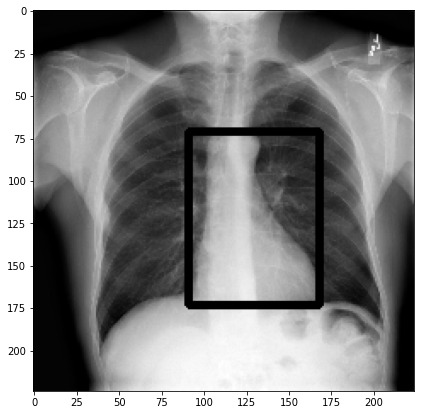

In [5]:
for features in parsed_dataset.take(1):
    for key in features.keys():
        if key == "label":
            labels = features[key].numpy()
            print(f"{key} / 244: {features[key] / 244}")
    
    image = features["image"].numpy()
    cv2.rectangle(image,pt1=(labels[0],labels[1]),pt2=(labels[2],labels[3]),color=(0,255,255),thickness=3)
    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(image,cmap='gray')
    plt.show()

# <font color='purple'>Train with TFRecord</font>

In [6]:
def parse_data(sample):
    feature_description = {
        'image':tf.io.FixedLenFeature([], tf.string),
        'label':tf.io.FixedLenSequenceFeature([], tf.int64,allow_missing=True),
    }
    # Binary
    sample = tf.io.parse_single_example(sample, feature_description)
    # Image
    sample['image'] = tf.io.decode_png(sample['image'],channels=1)
    return sample

def prepare_sample(sample):
    image = tf.cast(sample['image'],dtype=tf.float16)
    image = image / 255.0
   
    label = tf.cast(sample['label'],dtype=tf.float16)
    label = label / 244.0
    
    
    return image, label

def get_dataset(filenames, batch_size, train_test = 'train'):
    if train_test == 'train':
        dataset = (
            tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
            .map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)
            .map(prepare_sample, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(batch_size * 10)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )
        
        return dataset
    elif train_test == 'test':
        dataset = (
            tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
            .map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)
            .map(prepare_sample, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )
        
        return dataset

### Prepare Datasets

In [7]:
train_data = get_dataset(tf_records[0],batch_size=32,train_test='train')
test_data = get_dataset(tf_records[1],batch_size=32,train_test='test')

### Prepare Model: ResNet with MSE

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
es = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights= True)

In [10]:
base_model = ResNet50(input_shape=(224,224,1),
                         include_top=False,weights=None,pooling='max')

# Customize the output layers
flatten_all = tf.keras.layers.Flatten()(base_model.output)
Dense_1 = tf.keras.layers.Dense(units=16,activation='relu')(flatten_all)
Dense_2 = tf.keras.layers.Dense(units=8,activation='relu')(Dense_1)
prediction_layer = tf.keras.layers.Dense(units=4)(Dense_2)

# Concatenate the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [11]:
history = model.fit(train_data,
    validation_data = test_data,
    epochs=100,
    callbacks=[es]
)

Epoch 1/100
22/22 [==============================] - 18s 464ms/step - loss: 3.4292 - val_loss: 0.4482
Epoch 2/100
22/22 [==============================] - 7s 329ms/step - loss: 0.2070 - val_loss: 0.3347
Epoch 3/100
22/22 [==============================] - 7s 316ms/step - loss: 0.1757 - val_loss: 0.2450
Epoch 4/100
22/22 [==============================] - 7s 311ms/step - loss: 0.1573 - val_loss: 0.1389
Epoch 5/100
22/22 [==============================] - 7s 319ms/step - loss: 0.1440 - val_loss: 0.0886
Epoch 6/100
22/22 [==============================] - 8s 349ms/step - loss: 0.1333 - val_loss: 0.0750
Epoch 7/100
22/22 [==============================] - 8s 364ms/step - loss: 0.1166 - val_loss: 0.0766
Epoch 8/100
22/22 [==============================] - 8s 360ms/step - loss: 0.1060 - val_loss: 0.0614
Epoch 9/100
22/22 [==============================] - 8s 358ms/step - loss: 0.0974 - val_loss: 0.0561
Epoch 10/100
22/22 [==============================] - 8s 370ms/step - loss: 0.0884 - val_l

In [32]:
import pandas as pd
from PIL import Image

In [33]:
losses = pd.DataFrame(history.history)

<AxesSubplot:>

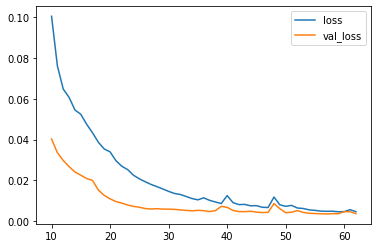

In [35]:
losses[10:].plot()

### Evaluation

In [12]:
images = []
labels = []
for imgs,lbls in test_data.take(1):
    imgs = tf.image.grayscale_to_rgb(imgs)
    for img, lbl in zip(imgs,lbls):
        image = img.numpy()
        images.append(image)
        label = lbl.numpy()
        labels.append(label)
#     print(x.shape,y)
len(images),len(labels)

(32, 32)

In [13]:
loc_predictions = model.predict(test_data.take(1))

In [14]:
gl = tfa.losses.GIoULoss(mode = 'iou')

In [15]:
gl(labels,loc_predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3481445>

#### Draw on Image

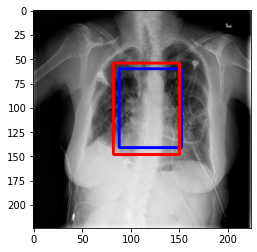

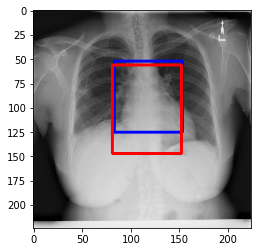

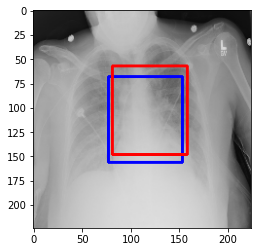

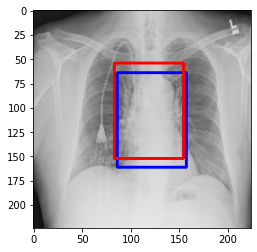

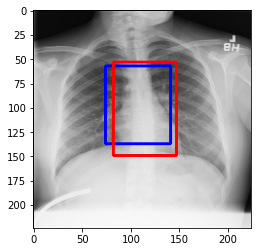

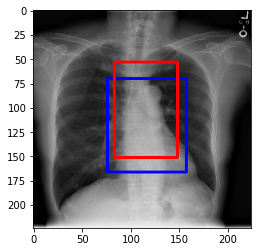

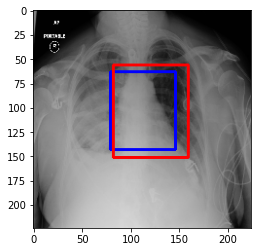

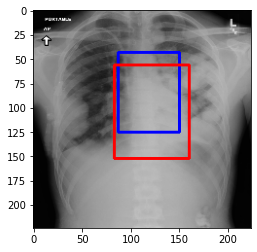

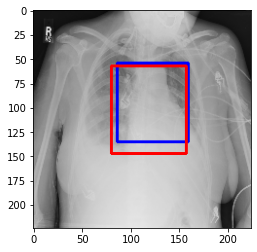

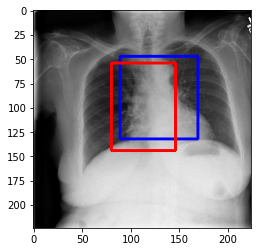

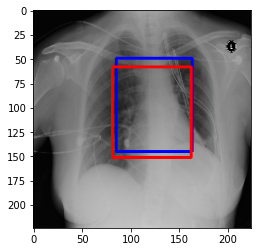

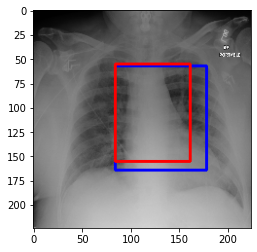

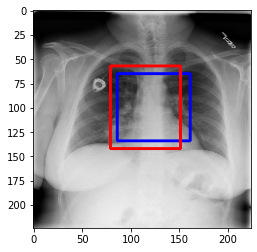

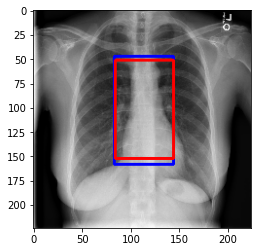

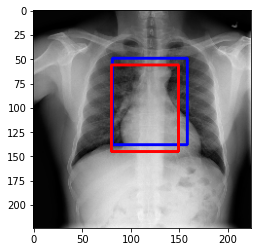

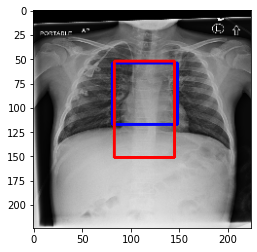

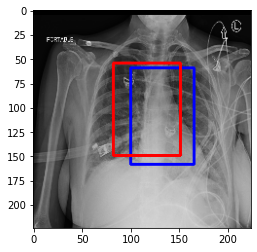

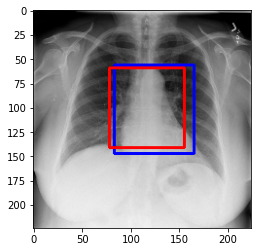

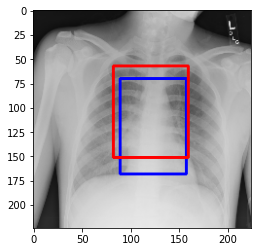

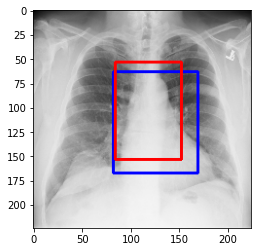

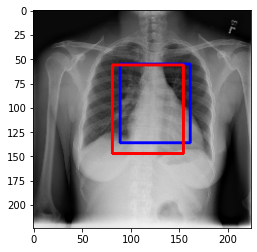

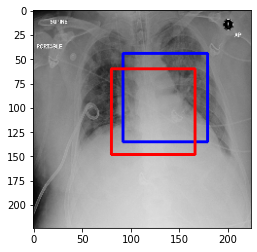

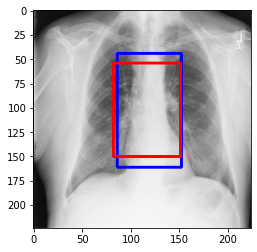

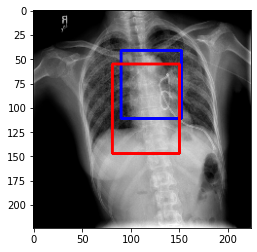

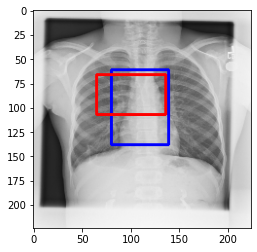

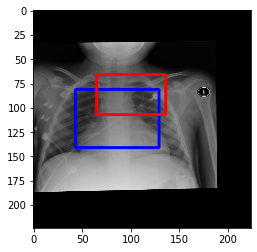

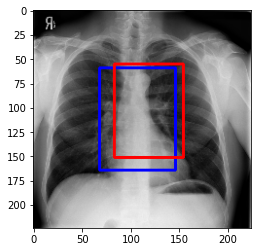

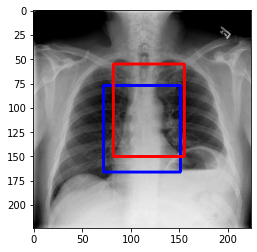

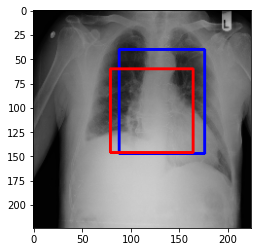

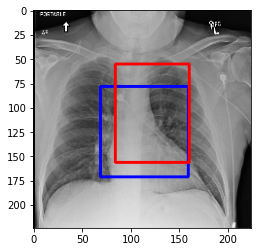

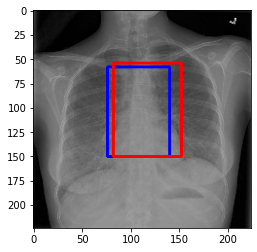

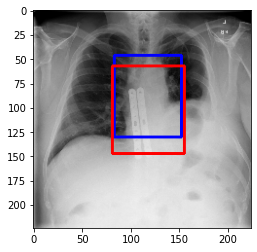

In [41]:
cnt = 0
for image, label, preds in zip(images,labels,loc_predictions):
    # Denormalize
    image = image * 255
    image = image.astype(int)
    
    # Actual Label
    label = label * 224
    label = label.astype(int)
    
    # Pred Label
    preds = preds * 224
    preds = preds.astype(int)
    
    # Draw on Image
    cv2.rectangle(image,pt1=(label[0],label[1]),
                  pt2=(label[2],label[3]),
                  color=(0,0,255),thickness=2)
    
    cv2.rectangle(image,pt1=(preds[0],preds[1]),
              pt2=(preds[2],preds[3]),
              color=(255,0,0),thickness=2)
    cnt+=1
    cv2.imwrite(f'heart_{cnt}.png',image)
    plt.imshow(image)
    plt.show()


In [47]:
paths = glob.glob('heart_*.png')
images = []

for path in paths:
    im = Image.open(path)
    images.append(im)
    
images[0].save('zombie_detector.gif',
               save_all=True, append_images=images[1:], optimize=True, duration=1000, loop=0)

In [22]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou


print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

In [31]:
iou = intersection_over_union(np.array(labels), loc_predictions)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

Number of predictions where iou > threshold(0.5): 29
Number of predictions where iou < threshold(0.5): 3
